## Identification and classification of damaged/flooded buildings from post-hurricane satellite images

## 3.1 Pre-Processing, Training and Modeling (Part I)  : Introduction

In this notebook, we prepare the training and test data set. Next we build the first simple base line model to be used as a bench mark.


## 3.2 Import relevant libraries

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path
from PIL import Image
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import montage
from tqdm import tqdm, tqdm_notebook # for progress bar
tqdm.pandas() # instantiate

import cv2

from sklearn.model_selection import train_test_split

## 3.3 Read saved data

In [4]:
image_df_all = (pd.read_csv('./data/All_images_with_features.csv')).drop('Unnamed: 0', axis=1)

In [5]:
image_df_all.head()

,index,path,damage,data_split,location,lon,lat,color_features,x,y,resnet_features,x1,y1,z1
0,0,raw_data/test_another/damage/-96.86103_28.3637...,damage,test_another,-96.86103_28.363781,-96.861030,28.363781,[4.88281250e-04 0.00000000e+00 0.00000000e+00 ...,13.491997,8.466843,[1.1303113 0.9624331 5.366783 ... 1.2222589 0...,13.492067,8.467100,10.482869
1,1,raw_data/test_another/damage/-96.891574_28.364...,damage,test_another,-96.891574_28.364215,-96.891574,28.364215,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,2.628940,8.487952,[0.33010513 3.6861324 0.05639834 ... 0. ...,2.628948,8.488042,8.832417
2,2,raw_data/test_another/damage/-96.861869_28.364...,damage,test_another,-96.861869_28.364221,-96.861869,28.364221,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,11.246094,5.521062,[2.6203313 0.47271124 1.1984255 ... 0.176002...,11.246102,5.520958,10.913705
3,3,raw_data/test_another/damage/-96.8745319999999...,damage,test_another,-96.87453199999999_28.371883,-96.874532,28.371883,[5.49316406e-04 0.00000000e+00 0.00000000e+00 ...,9.405262,8.846469,[2.0739737 1.4798961 2.299284 ... 0.112682...,9.405270,8.846631,2.472754
4,4,raw_data/test_another/damage/-96.874309_28.372...,damage,test_another,-96.874309_28.372196000000002,-96.874309,28.372196,[6.71386719e-04 0.00000000e+00 0.00000000e+00 ...,16.837591,0.416875,[1.6763107 5.627882 2.5987031 ... 0.029406...,16.837591,0.417198,4.835451


In [6]:
image_df_all['data_split'].value_counts()

train_another         10000
test_another           9000
test                   2000
validation_another     2000
Name: data_split, dtype: int64

## 3.3 Base Line Model

We will start preparing the vector for training and testing. Two sets of features that were generated in the previous notebook will be used. The two sets of feature are:
- Color features extracted from the images
- Features generated using the resnet50 

We will train a simple baseline model using KNN using these two sets of feature and compare the results

### 3.3.1 Model training using color features

In [258]:
# # train_df = image_df_all[image_df_all['data_split']=='train_another']
# train_df = image_df_all.query('data_split=="train_another"')
# train_df.reset_index(inplace=True)
# train_df.head()

In [259]:
# X_train = np.stack(train_df['color_features'].values, 0)
# y_train = np.stack(train_df['damage'], 0)
# print(X_train.shape, y_train.shape)

In [250]:
# Read the color features'
image_df_col = pd.read_json('./color_features.json')
image_df_col['damage'] = image_df_col['damage'].map(lambda x: x=='damage') 
image_df_col.sample(3)

,index,path,damage,data_split,location,lon,lat,color_features,x,y
16503,3503,raw_data/train_another/damage/-95.642562_29.77...,True,train_another,-95.642562_29.770945,-95.642562,29.770945,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.138274,-0.030454
20024,7024,raw_data/train_another/no_damage/-95.632013_29...,False,train_another,-95.632013_29.849137,-95.632013,29.849137,"[0.00030517580000000003, 0.0, 0.0, 0.0, 0.0, 0...",-0.070313,-0.056462
4997,4997,raw_data/test_another/no_damage/-95.633134_29....,False,test_another,-95.633134_29.777668,-95.633134,29.777668,"[0.00048828120000000004, 0.0, 0.0, 0.0, 0.0, 0...",0.078612,0.013785


In [251]:
# Use the train_another dataset to train the model. Prepare the training and target features
train_df_col = image_df_col.query('data_split=="train_another"')
train_df_col.reset_index(inplace=True)
print(train_df.shape)

train_x_col = np.stack(train_df_col['color_features'].values, 0)
train_y_col = np.stack(train_df_col['damage'], 0)
print(train_x_col.shape, train_y_col.shape)

(10000, 11)
(10000, 255) (10000,)


In [262]:
from sklearn.neighbors import KNeighborsRegressor
knn_col = KNeighborsRegressor(n_neighbors=1)
knn_col.fit(train_x_col, train_y_col)

KNeighborsRegressor(n_neighbors=1)

#### Helper Function to print and plot model metrics

In [272]:
import itertools
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_model_results(in_model, df,features,use_split=None, plot_type='swarm'):
    """
    Function to plot the prediction results of a certain model. 
    It plots and prints ROC curve, confusion matrix, accuracy and classification report
    
    """
    fig, m_axs = plt.subplots(2, 2, figsize=(12, 12))
    m_axs = m_axs.flatten()
    all_rows = []
    classfication_report_df = pd.DataFrame()
    ax1 = m_axs[0]
#     ax1 = m_axs
    if use_split is None:
        cur_df = df.copy()
    else:
        cur_df = df.query('data_split=="{}"'.format(use_split)) 
    k=1    
    for c_split, example_df in cur_df.groupby('data_split'):

        if c_split != 'train_another' :
            example_df = example_df.reset_index()
            x_vec = np.stack(example_df[features].values, 0)
            y_vec = np.stack(example_df['damage'], 0)

            valid_pred = in_model.predict(x_vec)
            fpr, tpr, _ = roc_curve(y_vec[:], valid_pred[:])
            auc = roc_auc_score(y_vec[:], valid_pred[:])
            acc = accuracy_score(y_vec[:], valid_pred[:]>0.5)

            cnf_matrix = confusion_matrix(y_vec[:], valid_pred[:])
            class_report = classification_report(y_vec[:], valid_pred[:], output_dict=True)
            class_report_df = pd.DataFrame(class_report).transpose()
            class_report_df['split'] = c_split
            classfication_report_df = pd.concat([classfication_report_df,class_report_df],axis=0)

            # Plot ROC curve
            ax1.plot(fpr, tpr, '.-', label='{}, AUC {:0.2f}, Accuracy: {:2.0%}'.format(c_split, auc, acc))
            all_rows += [pd.DataFrame({'class': y_vec[:], 'prediction': np.clip(valid_pred[:], 0, 1), 'type': 'damage', 
                                      'split': c_split})]

            ax1.legend(loc='lower right')
            ax1.set_xlabel('False Positive Rate (FPR)')
            ax1.set_ylabel('True Positive Rate (TPR)') 
            
            #  plot_confusion_matrix(cnf_matrix, classes=class_names)
            ax = m_axs[k]
            class_names = ['True','False']
            im = ax.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.set_title('Confusion Matrix : {}'.format(c_split))

            tick_marks = np.arange(len(class_names))
            ax.set_xticks(tick_marks, class_names, rotation=45)
            ax.set_yticks(tick_marks, class_names)
            ax.set_ylabel('True label')
            ax.set_xlabel('Predicted label')  
            
            # for colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
            # Just to write the values in the confusion matrix
            fmt = 'd'
            thresh = cnf_matrix.max() / 2.
            for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                ax.text(j, i, format(cnf_matrix[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cnf_matrix[i, j] > thresh else "black")


            plt.tight_layout()
            
            k = k + 1

    c_all_df = pd.concat(all_rows)

    return classfication_report_df,c_all_df



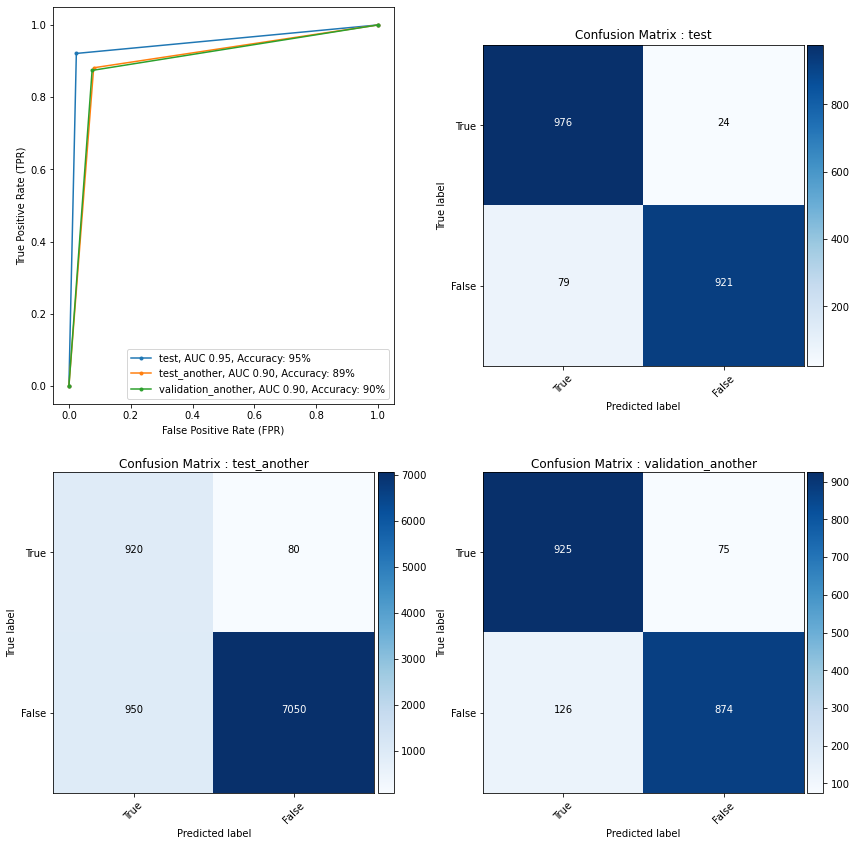

In [273]:
classfication_report_df, result_df = show_model_results(knn_col, image_df_col, 'color_features')

classfication_report_df.head(15)

The base line model built using the color features actually performed reasonably well. AOC of 90% for test_another and validation datasets and 95% AOC for the test data. However, when the test dataset is highly unbalanced, as in the case of the test_another (1000 no-damage class vs 8000 damage class), the precision of the simple baseline model suffers alot. It produced a precision of 49% for the unbalanced data compared to ~ 90% precison for the balanced datasets.

Next we train using similar KNN model but using the resnet50 features

### 3.3.1 Model training using Resnet50 features


In [90]:
# Read the resnet features'
image_df_resnet = pd.read_json('./resnet_features.json')
image_df_resnet['damage'] = image_df_resnet['damage'].map(lambda x: x=='damage') 
image_df_resnet.sample(3)


,index,path,damage,data_split,location,lon,lat,color_features,x,y,resnet_features,x1,y1,z1
12430,1430,raw_data/validation_another/no_damage/-95.6333...,False,validation_another,-95.633306_29.852415,-95.633306,29.852415,"[0.0001831055, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",25.392065,-15.399041,"[0.0247803628, 0.31377032400000004, 1.15121781...",25.392048,-15.399152,4.425117
21188,8188,raw_data/train_another/damage/-93.981558999999...,True,train_another,-93.98155899999999_29.898913,-93.981559,29.898913,"[0.00012207030000000001, 0.0, 0.0, 0.0, 0.0, 0...",-5.289604,8.648987,"[0.0957442746, 0.9225569963, 1.341045022, 0.0,...",-5.289598,8.648984,4.072215
22669,9669,raw_data/train_another/no_damage/-95.157519999...,False,train_another,-95.15751999999999_30.072542,-95.157520,30.072542,"[0.0024414062, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",-16.361124,-1.973304,"[0.0, 0.00226143, 0.047160808000000005, 0.0, 0...",-16.361122,-1.973397,-1.471073


In [92]:
# Use the train_another dataset to train the model. Prepare the training and target features
train_df_resnet = image_df_resnet.query('data_split=="train_another"')
train_df_resnet.reset_index(inplace=True)

train_x_resnet = np.stack(train_df_resnet['resnet_features'].values, 0)
train_y_resnet = np.stack(train_df_resnet['damage'], 0)
print(train_x_resnet.shape, train_y_resnet.shape)

(10000, 2048) (10000,)


In [93]:
knn_resnet = KNeighborsRegressor(n_neighbors=1)
knn_resnet.fit(train_x_resnet, train_y_resnet)

KNeighborsRegressor(n_neighbors=1)

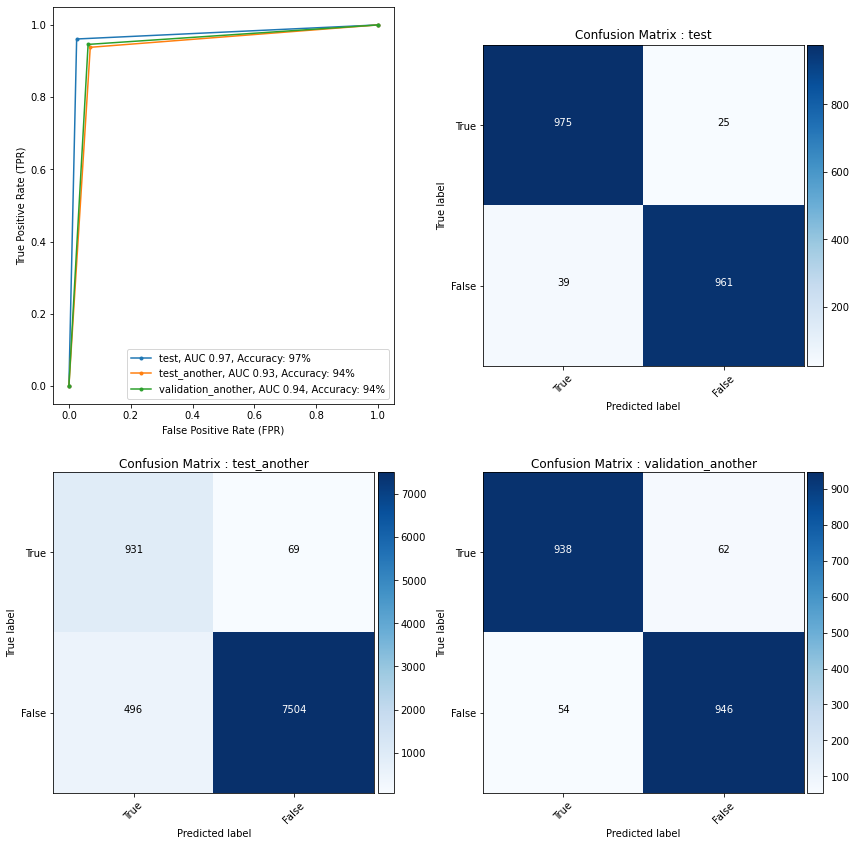

In [264]:
classfication_report_resnet_df, result_resnet_df = show_model_results(knn_resnet, image_df_resnet, 'resnet_features')
# show_model_results(knn_resnet,image_df_resnet,'resnet_features')

In [265]:
classfication_report_resnet_df

,precision,recall,f1-score,support,split
False,0.961538,0.975000,0.968222,1000.000000,test
True,0.974645,0.961000,0.967774,1000.000000,test
accuracy,0.968000,0.968000,0.968000,0.968000,test
macro avg,0.968092,0.968000,0.967998,2000.000000,test
weighted avg,0.968092,0.968000,0.967998,2000.000000,test
False,0.652418,0.931000,0.767202,1000.000000,test_another
True,0.990889,0.938000,0.963719,8000.000000,test_another
accuracy,0.937222,0.937222,0.937222,0.937222,test_another
macro avg,0.821653,0.934500,0.865461,9000.000000,test_another
weighted avg,0.953281,0.937222,0.941884,9000.000000,test_another


Overall there is ~4% improvement in AOC and accuracy by using the resnet features compared to the results using color features. The precison of the unbalanced dataset improved from 49% to 65%

## 3.4 Summary

We have trained a simple basle line model using K nearest Neighbor (KNN) method using color only features and more complex features generated from resnet50 model.

For a simple and fast model, these base lines model's performnce was quite good. The only major problem was when the test dataset is unbalanced. the precision suffered when given unbalanced dataset. The precision was 49% and 65% using the color features and resnet features respectively. Usinf more complex features does help improve accuracy and performance of the model with overall increas of ~4%. The results of the base line models are summarized in the table below.


<img src = "./Baseline_Model_Classification_report.png" alt="drawing" width="800"/>
